In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
ranking_methods = [
    lambda i: i.at['Gold'  ],
    lambda i: i.at['Total' ],
    lambda i: i.at['Gold'  ] * 5 +\
              i.at['Silver'] * 3 +\
              i.at['Bronze'] * 1
]

class Ranking(Enum):
    Gold = 0
    Total = 1
    FiveThreeOne = 2

    def do(self, data):
        return ranking_methods[self.value](data)

In [3]:
database = pd.read_csv('MedalsByCountry.csv')
countries = list(database['Team/NOC'])
COUNTRY_COUNT = len(countries)

In [4]:
data = np.zeros((len(Ranking), COUNTRY_COUNT))

for kind in Ranking:
    for country in range(COUNTRY_COUNT):
        data[kind.value, country] = kind.do(database.loc[country])

In [5]:
def massey(data: np.array) -> np.array:

    M = np.matrix(np.zeros((COUNTRY_COUNT, COUNTRY_COUNT)))
    for ind, _ in np.ndenumerate(M):
        M[ind] = -1 if ind[0] != ind[1] else COUNTRY_COUNT-1

    p = np.array([
        sum(pointsA - pointsB for B, pointsB in enumerate(data) if B != A)
        for A, pointsA in enumerate(data)
    ])

    M[-1, :] = 1
    p[-1] = 0

    r = M.I * np.matrix(p).T
    return np.array(r.flatten())[0]

In [6]:
def colley(data: np.array) -> np.array:

    C = np.matrix(np.zeros((COUNTRY_COUNT, COUNTRY_COUNT)))
    for ind, _ in np.ndenumerate(C):
        C[ind] = -1 if ind[0] != ind[1] else COUNTRY_COUNT+1

    b = np.array([
        sum(
            ((pointsA > pointsB) * 2 - 1) * (pointsA != pointsB) # 1, -1 ou 0
            for B, pointsB in enumerate(data) if B != A
        )   for A, pointsA in enumerate(data)
    ]) * 0.5 + 1

    r = C.I * np.matrix(b).T
    return np.array(r.flatten())[0]

In [7]:
df = pd.DataFrame()
df['Country'] = countries

for method in (massey, colley):
    for kind in Ranking:
        rating = method(data[kind.value])

        order = sorted(
            zip(range(COUNTRY_COUNT), rating), key=lambda i: i[1], reverse=True
        )

        reorder = sorted(
            enumerate(order), key=lambda i: i[1][0]
        )

        df['Rating'] = rating
        df['Rank'] = [i[0] + 1 for i in reorder]


        name = f"{method.__name__}_{kind.name}"
        df.to_csv(f"{name}.csv", index=False)

        database[name] = df['Rank']

database.to_csv("Complete.csv", index=False)

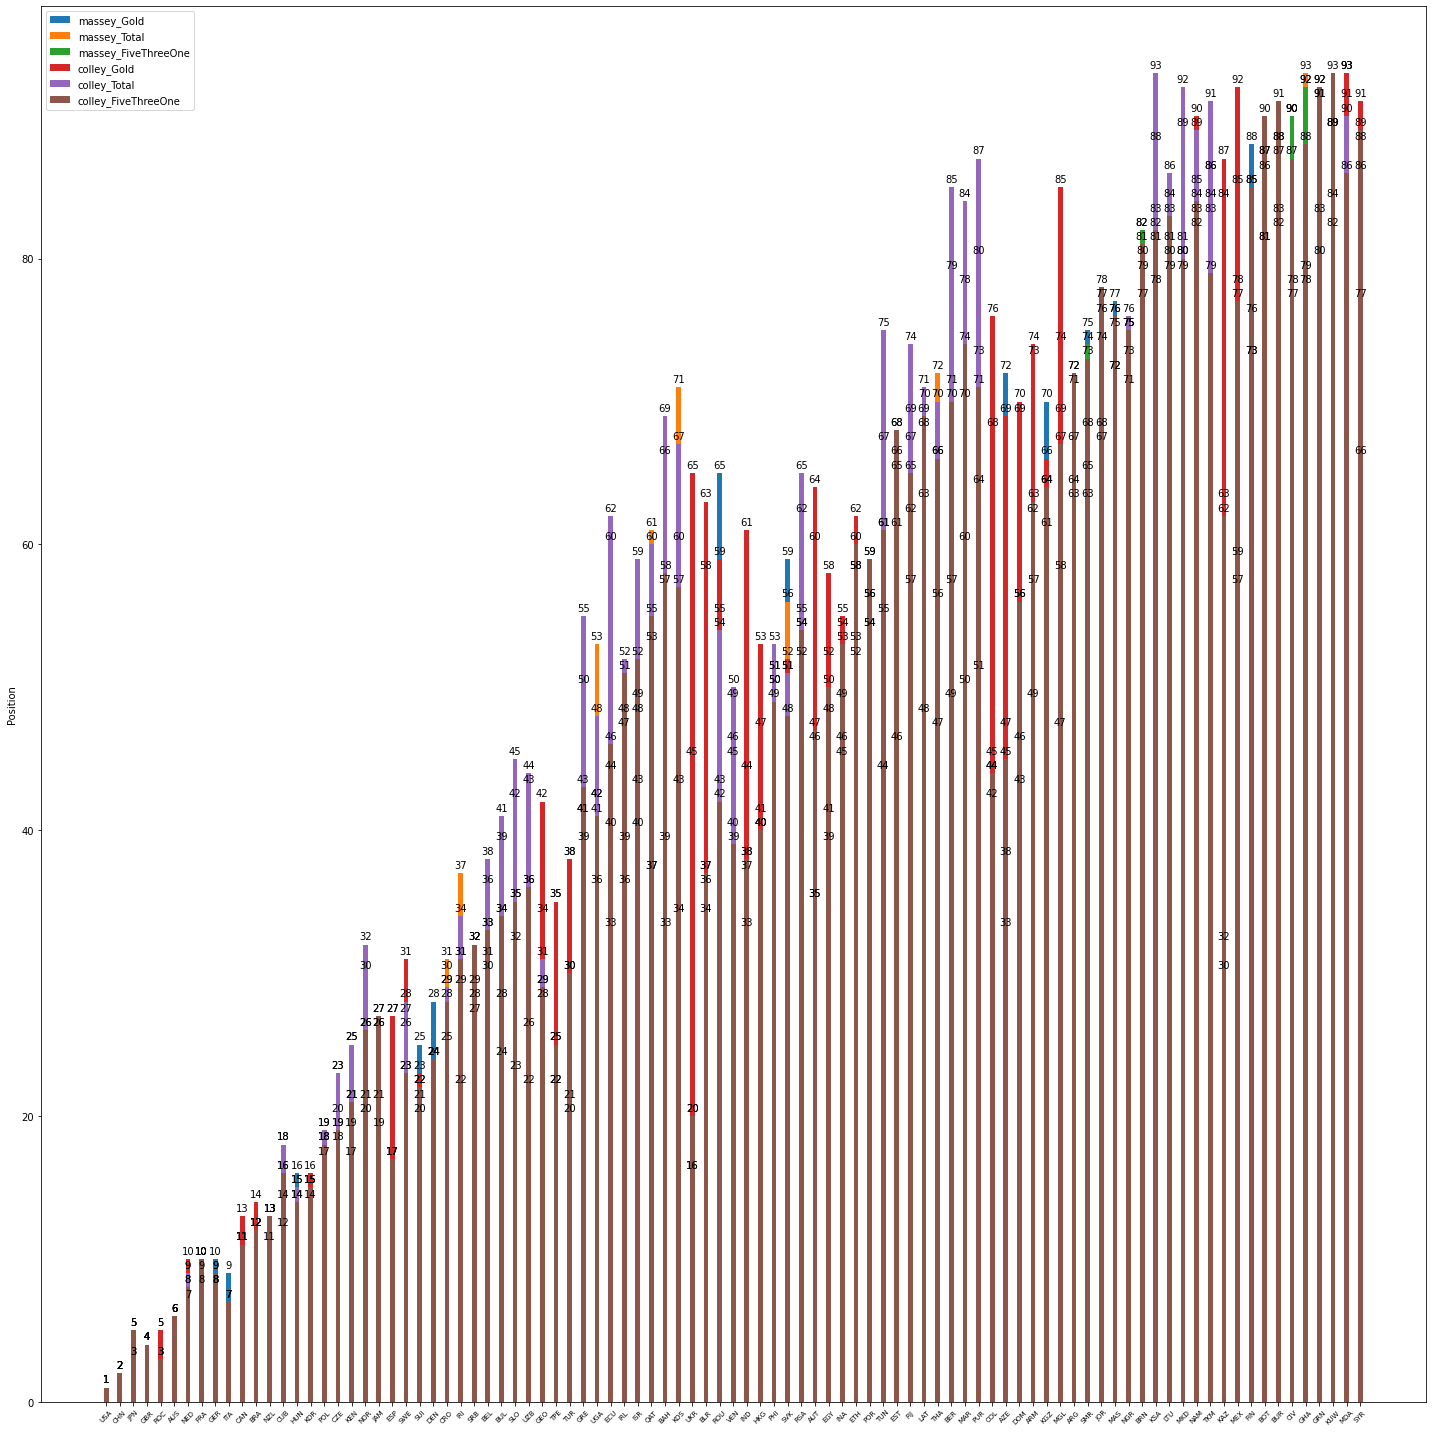

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20,20]

fig, ax = plt.subplots()
num_bars = len(Ranking) * 2
x = np.arange(len(countries))
width = 0.35

bars = []

for method in (massey, colley):
    for kind in Ranking:
        name = f"{method.__name__}_{kind.name}"
        bars.append(ax.bar(x, database[name].to_numpy(), width, label=name))


ax.set_ylabel('Position')
ax.set_xticks(x)
ax.set_xticklabels(database['NOCCode'], rotation=45, size='x-small')
ax.legend()

for bar in bars: ax.bar_label(bar, padding=3)

fig.tight_layout()
plt.show()

## Posição (menor é melhor)